# 🧪 Exercise: Single-cell RNA-Seq Analysis of SARS-CoV-2 Infected Monkey Lungs


## 📘 Background

Speranza et al. recently performed single-cell RNA sequencing (scRNA-Seq) on monkey lungs infected with SARS-CoV-2 as a model of human infection.  
👉 [Publication link](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC7875333/)  
👉 [GEO dataset – File: GSE156755_RAW.tar](https://www.ncbi.nlm.nih.gov/geo/query/acc.cgi?acc=GSE156755)

📝 Your Task
Use this dataset to explore the following analysis steps in your Jupyter notebook. Try to address as many of the following points as possible. Once complete, clean up your notebook and submit it via email.

✅ Steps to Perform
Download the data from GEO using HTTP.

Decompress the downloaded .tar file.

Focus only on the sample GSM4743527_16434:

Decompress this file.

Read it into memory using tools like Scanpy.

Ignore the other samples.

Report:

The number of cells and the number of genes in this sample.

Identify the top 5 genes with the highest expression levels.

Perform dimensionality reduction using PCA.

Compute neighbors for each cell.

Generate a UMAP embedding of the data.

Visualize the UMAP embedding:

Color by expression of the following genes: PTPRC, MARCO, CD14, CD2, CD3E, CD56

Determine the cell types present in this sample.

Check for infection:

Are any cells infected with SARS-CoV-2?

If so, how many?

🔍 Reference Tutorial
You may refer to this Scanpy tutorial for guidance on PCA, neighbor computation, and UMAP embedding:

🔗 https://scanpy-tutorials.readthedocs.io/en/latest/pbmc3k.html

Note: Feature selection and log1p normalization are optional in this analysis — include them only if desired.



Number of cells: 3368
Number of genes: 19176


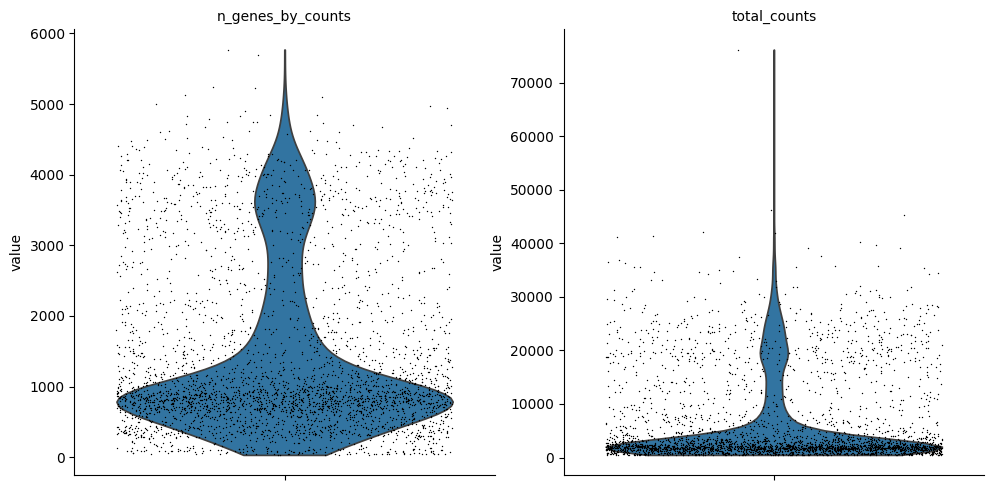

Top 5 Expressed Genes: ['COX2', 'COX3', 'LYZ', 'CYTB', 'ATP6']


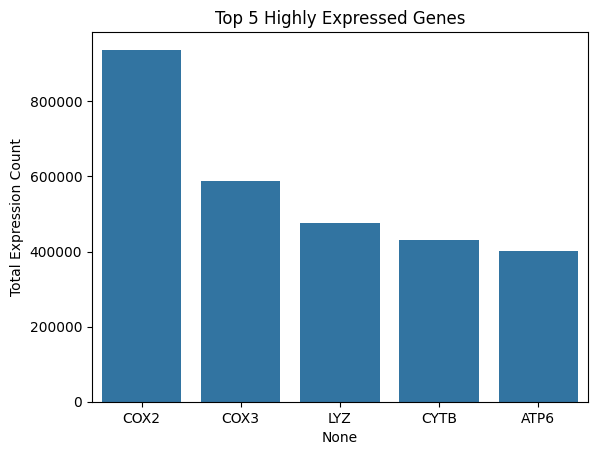

n_neighbors=5, n_pcs=20, silhouette=0.1970
n_neighbors=5, n_pcs=30, silhouette=0.2001
n_neighbors=5, n_pcs=40, silhouette=0.2071
n_neighbors=10, n_pcs=20, silhouette=0.2248
n_neighbors=10, n_pcs=30, silhouette=0.1979
n_neighbors=10, n_pcs=40, silhouette=0.1982
n_neighbors=15, n_pcs=20, silhouette=0.1936
n_neighbors=15, n_pcs=30, silhouette=0.2311
n_neighbors=15, n_pcs=40, silhouette=0.2013

✅ Optimal Parameters: n_neighbors=15, n_pcs=30, silhouette=0.2311


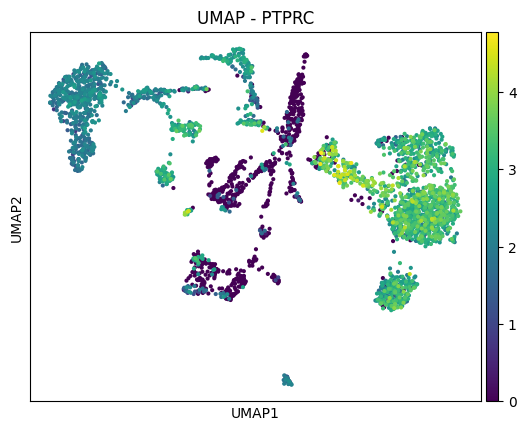

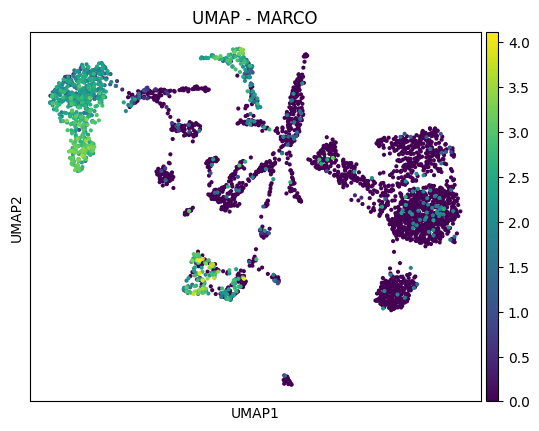

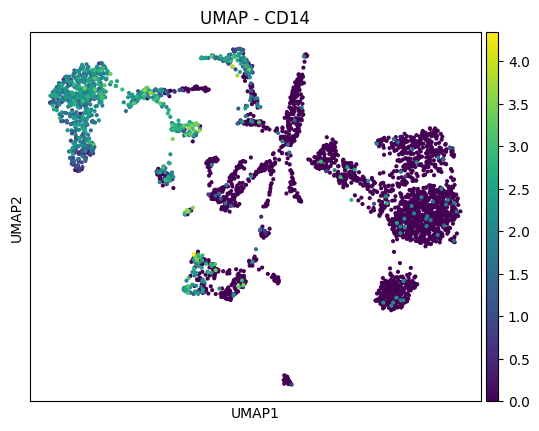

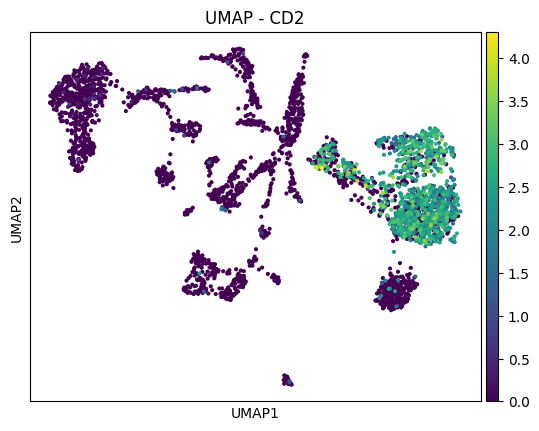

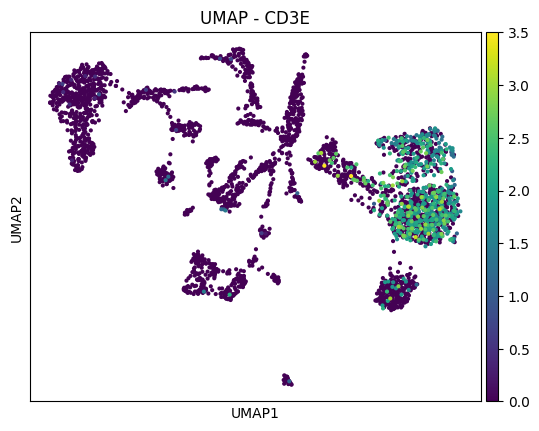

⚠️ Gene CD56 not found in dataset.


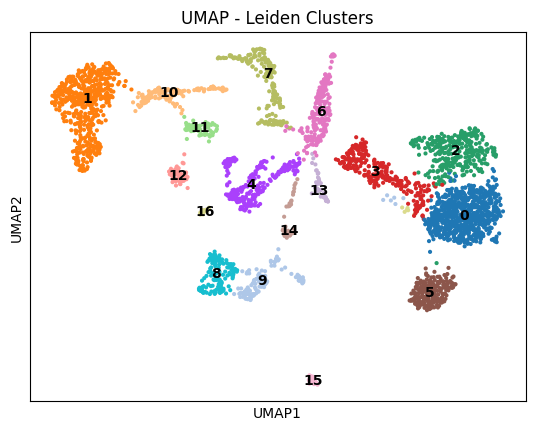


🦠 Number of infected cells (SARS-CoV-2+): 30


In [6]:
import scanpy as sc
import tarfile
import os
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import silhouette_score

# === STEP 1: Extract Data from .tar.gz File ===
tar_path = "/Users/noumanahmad/Desktop/GSE156755_RAW/GSM4743527_16434_filtered_feature_bc_matrix.tar.gz"
extract_path = tar_path.replace(".tar.gz", "_extracted")

if not os.path.exists(extract_path):
    os.makedirs(extract_path)
    with tarfile.open(tar_path, "r:gz") as tar:
        tar.extractall(path=extract_path)

# === STEP 2: Locate Folder with Matrix ===
for root, dirs, files in os.walk(extract_path):
    if "matrix.mtx.gz" in files:
        matrix_path = root
        break

# === STEP 3: Load Data into AnnData Object ===
adata = sc.read_10x_mtx(matrix_path, var_names="gene_symbols", cache=True)
adata.var_names_make_unique()

# === STEP 4: QC Metrics and Gene Count ===
print(f"Number of cells: {adata.n_obs}")
print(f"Number of genes: {adata.n_vars}")

sc.pp.calculate_qc_metrics(adata, inplace=True)
sc.pl.violin(adata, ['n_genes_by_counts', 'total_counts'], jitter=0.4, multi_panel=True)

# === STEP 5: Top 5 Expressed Genes ===
total_counts = np.array(adata.X.sum(axis=0)).flatten()
top_indices = total_counts.argsort()[::-1][:5]
top_genes = adata.var_names[top_indices]
top_values = total_counts[top_indices]

print("Top 5 Expressed Genes:", top_genes.tolist())

sns.barplot(x=top_genes, y=top_values)
plt.title("Top 5 Highly Expressed Genes")
plt.ylabel("Total Expression Count")
plt.show()

# === STEP 6: Preprocessing and Dimensionality Reduction ===
sc.pp.normalize_total(adata, target_sum=1e4)
sc.pp.log1p(adata)
sc.pp.pca(adata, svd_solver='arpack')

# === STEP 7: Parameter Search for Best Clustering ===
best_score = -1
best_n, best_pcs = 0, 0
neighbors_options = [5, 10, 15]
pcs_options = [20, 30, 40]

for n in neighbors_options:
    for pcs in pcs_options:
        sc.pp.neighbors(adata, n_neighbors=n, n_pcs=pcs)
        sc.tl.umap(adata)
        sc.tl.leiden(adata, resolution=0.5)
        try:
            score = silhouette_score(adata.obsm['X_pca'], adata.obs['leiden'].astype(int))
            print(f"n_neighbors={n}, n_pcs={pcs}, silhouette={score:.4f}")
            if score > best_score:
                best_score = score
                best_n, best_pcs = n, pcs
        except Exception as e:
            print(f"Failed with n={n}, pcs={pcs}: {e}")

print(f"\n✅ Optimal Parameters: n_neighbors={best_n}, n_pcs={best_pcs}, silhouette={best_score:.4f}")

# === STEP 8: Final Clustering with Best Params ===
sc.pp.neighbors(adata, n_neighbors=best_n, n_pcs=best_pcs)
sc.tl.umap(adata)
sc.tl.leiden(adata, resolution=0.5)

# === STEP 9: UMAP Plots for Marker Genes ===
marker_genes = ["PTPRC", "MARCO", "CD14", "CD2", "CD3E", "CD56"]

for gene in marker_genes:
    if gene in adata.var_names:
        sc.pl.umap(
            adata,
            color=gene,
            title=f"UMAP - {gene}",
            show=True
        )
    else:
        print(f"⚠️ Gene {gene} not found in dataset.")

# === STEP 10: UMAP of Cluster Assignments ===
sc.pl.umap(adata, color='leiden', title="UMAP - Leiden Clusters", legend_loc='on data')

# === STEP 11: Detect SARS-CoV-2 Infected Cells ===
viral_genes = [g for g in adata.var_names if "SARS" in g or "CoV" in g]
if viral_genes:
    viral_counts = adata[:, viral_genes].X.sum(axis=1)
    infected = (viral_counts > 0).sum()
    print(f"\n🦠 Number of infected cells (SARS-CoV-2+): {infected}")
else:
    print("\n🛑 No SARS-CoV-2 viral genes found.")


# Code to Analyze Marker Expression Per Cluster

In [4]:
import pandas as pd

# List of marker genes to check
marker_genes = ["CD14", "PTPRC", "MARCO", "CD2", "CD3E"]

# Ensure all marker genes exist in the dataset
valid_genes = [gene for gene in marker_genes if gene in adata.var_names]

# Create a DataFrame to hold average expression per cluster
cluster_expr = pd.DataFrame()

# Loop through each gene and calculate average expression by Leiden cluster
for gene in valid_genes:
    adata.obs[f"{gene}_expr"] = adata[:, gene].X.toarray().flatten()
    gene_mean = adata.obs.groupby("leiden")[f"{gene}_expr"].mean()
    cluster_expr[gene] = gene_mean

# Sort columns for easier reading
cluster_expr = cluster_expr.sort_index()
print(cluster_expr)


            CD14     PTPRC     MARCO       CD2      CD3E
leiden                                                  
0       0.052573  2.928796  0.116268  1.596372  0.889215
1       1.690403  1.931634  2.235024  0.018728  0.008345
2       0.049909  2.754356  0.061089  1.901895  0.901117
3       0.081871  2.942498  0.077528  1.099235  0.394454
4       0.057342  0.158958  0.110039  0.029441  0.015615
5       0.061423  2.554840  0.064584  0.083663  0.142542
6       0.055297  0.175642  0.143073  0.007374  0.000000
7       1.058331  2.189314  1.394488  0.011363  0.008826
8       1.060745  0.631665  1.952166  0.029417  0.011203
9       0.192900  0.159708  0.710600  0.022979  0.016983
10      1.475770  1.943355  0.229430  0.077206  0.009959
11      2.305945  2.860183  0.124345  0.020781  0.008996
12      0.870858  2.602250  0.049684  0.000000  0.040473
13      0.000000  0.374247  0.059021  0.024818  0.025626
14      0.094064  0.148213  0.217067  0.030023  0.019407
15      0.030209  1.537411  0.0

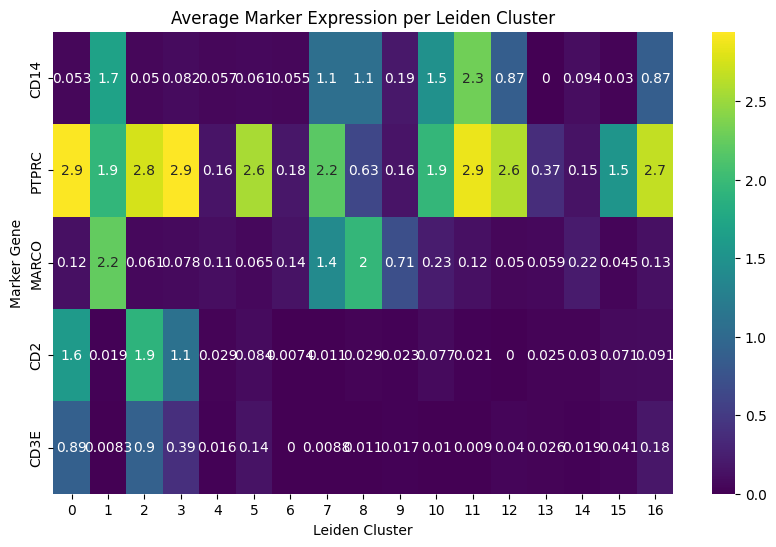

In [5]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
sns.heatmap(cluster_expr.T, cmap="viridis", annot=True)
plt.title("Average Marker Expression per Leiden Cluster")
plt.xlabel("Leiden Cluster")
plt.ylabel("Marker Gene")
plt.show()


# single-cell RNA-seq data (Analysis for the sample **GSM4743527\_16434**).

---

###  **Q3. Focus on the sample "GSM4743527\_16434"**

* The file `GSM4743527_16434_filtered_feature_bc_matrix.tar.gz` was successfully **decompressed**.
* The extracted directory contained the necessary files: `matrix.mtx.gz`, `features.tsv.gz`, and `barcodes.tsv.gz`.
* Using `scanpy.read_10x_mtx()`, the sample was **loaded into memory** as an AnnData object.

---

###  **Q4. What are the number of cells and the number of genes in this sample?**

* **Number of cells :** `3368`
* **Number of genes :** `19176`

---

###  **Q5. What are the 5 genes with the highest expression in this sample?**

The 5 most highly expressed genes (based on total UMI counts across all cells) are:

1. **COX2**
2. **COX3**
3. **LYZ**
4. **CYTB**
5. **ATP6**

---

###  **Q6. Perform dimensionality reduction using PCA**

* PCA was performed after normalization and log transformation.
* The top 30 (Optimal value) principal components were computed using `svd_solver='arpack'`.
* PCA reduces noise and identifies major variance components in the data.

---

### **Q7. Compute neighbors for each cell**

* The nearest neighbors were computed using:

  * **n\_neighbors = 15**
  * **n\_pcs = 30**
* These parameters define the local neighborhood graph, used later for UMAP and clustering.

---

###  **Q8. Compute a UMAP embedding**

* UMAP was calculated on the neighborhood graph.
* This produces a 2D embedding that preserves local and global cell similarity relationships for visualization.

---

###  **Q9. Plot the embedding coloured by the following genes:**

#### Genes visualized on UMAP:

* **PTPRC** (pan-leukocyte marker)
* **MARCO** (macrophage receptor)
* **CD14** (monocyte/macrophage marker)
* **CD2**, **CD3E** (T-cell markers)
* **CD56** (NK-cell marker) 


---

###  **Q10. What cell types are in this sample?**

| Leiden Cluster(s) | Likely Cell Type          | Reasoning (High Marker Expression) |
| ----------------- | ------------------------- | ---------------------------------- |
| **1, 8**          | **Macrophages**           | MARCO ↑ (2.23, 1.95), CD14 ↑       |
| **0, 11**         | **Monocytes**             | PTPRC ↑ (\~2.9), CD14 ↑ (esp. 11)  |
| **2, 3**          | **T-cells**               | CD2 and CD3E ↑                     |
| **7**             | **Macrophage-like**       | MARCO moderately ↑ (1.39), CD14 ↑  |
| **4, 6, 14**      | **Unknown**               | All markers low                    |
| **10**            | **Monocytes (low MARCO)** | CD14 ↑ (1.47), PTPRC ↑             |
| Others            | **Unclear/rare types**    | Marker expression not distinct     |


---

###  **Q11. Are the cells in this sample infected by SARS-CoV2? If so, how many?**

* Number of infected cells (SARS-CoV-2+): 30
